In [1]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, uniform

In [2]:
# Set units in international system (correct scale from GEE)
scale_bio = 0.1  # units ºC or mm
mean_bio01 = 133.389873 * scale_bio
mean_bio02 = 95.688608 * scale_bio
mean_bio05 = 261.9025323 * scale_bio
mean_bio08 = 160.1759493 * scale_bio
mean_bio14 = 41.4632913 * scale_bio
sd_bio01 = 58.437643 * scale_bio
sd_bio02 = 22.371996 * scale_bio
sd_bio05 = 42.6613913 * scale_bio
sd_bio08 = 66.1564813 * scale_bio
sd_bio14 = 27.6126673 * scale_bio

In [3]:
bio01_2030 = pd.read_csv('../../Data/AnnualMeanTemperature_2030.csv')
bio01_2050 = pd.read_csv('../../Data/AnnualMeanTemperature_2050.csv')
bio02_2030 = pd.read_csv('../../Data/MeanDiurnalRange_2030.csv')
bio02_2050 = pd.read_csv('../../Data/MeanDiurnalRange_2050.csv')
bio05_bio08_bio14_2030 = pd.read_csv('../../Data/BioclimaticVariables_2030.csv')
bio05_bio08_bio14_2050 = pd.read_csv('../../Data/BioclimaticVariables_2050.csv')

bio01_2030.rename(columns={'mean': 'bio01_raw'}, inplace=True)
bio01_2030['bio01'] = (bio01_2030['bio01_raw'] - 273.15 - mean_bio01) / sd_bio01

bio01_2050.rename(columns={'mean': 'bio01_raw'}, inplace=True)
bio01_2050['bio01'] = (bio01_2050['bio01_raw'] - 273.15 - mean_bio01) / sd_bio01

bio02_2030.rename(columns={'mean': 'bio02_raw'}, inplace=True)
bio02_2030['bio02'] = (bio02_2030['bio02_raw'] - mean_bio02) / sd_bio02

bio02_2050.rename(columns={'mean': 'bio02_raw'}, inplace=True)
bio02_2050['bio02'] = (bio02_2050['bio02_raw'] - mean_bio02) / sd_bio02

# Rename and scale bio05, bio08, and bio14 for 2030
bio05_bio08_bio14_2030.rename(columns={'bio05': 'bio05_raw', 'bio08': 'bio08_raw', 'bio14': 'bio14_raw'}, inplace=True)
bio05_bio08_bio14_2030['bio05'] = (bio05_bio08_bio14_2030['bio05_raw'] - 273.15 - mean_bio05) / sd_bio05
bio05_bio08_bio14_2030['bio08'] = (bio05_bio08_bio14_2030['bio08_raw'] - 273.15 - mean_bio08) / sd_bio08
bio05_bio08_bio14_2030['bio14'] = (bio05_bio08_bio14_2030['bio14_raw'] - mean_bio14) / sd_bio14

# Rename and scale bio05, bio08, and bio14 for 2050
bio05_bio08_bio14_2050.rename(columns={'bio05': 'bio05_raw', 'bio08': 'bio08_raw', 'bio14': 'bio14_raw'}, inplace=True)
bio05_bio08_bio14_2050['bio05'] = (bio05_bio08_bio14_2050['bio05_raw'] - 273.15 - mean_bio05) / sd_bio05
bio05_bio08_bio14_2050['bio08'] = (bio05_bio08_bio14_2050['bio08_raw'] - 273.15 - mean_bio08) / sd_bio08
bio05_bio08_bio14_2050['bio14'] = (bio05_bio08_bio14_2050['bio14_raw'] - mean_bio14) / sd_bio14


In [4]:
# Extract ml info
df_ML_train = pd.read_csv('../../Data/df_ML_train_global_regressor_V0.csv')
df_ML_test = pd.read_csv('../../Data/df_ML_test_global_regressor_V0.csv')

In [5]:
df_ML_test[['sampling_year', 'site_id', 'study_id','bio01', 'bio02', 'bio05', 'bio08','bio14']].head()

,sampling_year,site_id,study_id,bio01,bio02,bio05,bio08,bio14
0,2016,Angel,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.825152,-0.639935,0.817179,-0.169621,-1.531466
1,2016,Francisco1,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.807510,-0.181407,1.128032,-0.664441,-1.531466
2,2016,Francisco2,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.825152,-0.135555,1.175856,-0.680403,-1.531466
3,2016,Juanantonio,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.807510,-0.502376,0.888915,-0.648479,-1.531466
4,2016,Manoli,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,NaN,NaN,NaN,NaN,NaN


In [6]:
df_ML_test_2030 = df_ML_test.copy()

# List of bioclimatic variables and their corresponding DataFrames
bioclim_variables = [
    ('bio01', bio01_2030),
    ('bio02', bio02_2030),
    ('bio05', bio05_bio08_bio14_2030),
    ('bio08', bio05_bio08_bio14_2030),
    ('bio14', bio05_bio08_bio14_2030)
]

# Loop to update each bioclimatic variable
for bio_var, bio_df in bioclim_variables:
    # Perform the temporary merge to get new values
    df_merged = df_ML_test_2030.merge(bio_df[['sampling_year', 'site_id', 'study_id', bio_var]],
                                      on=['sampling_year', 'site_id', 'study_id'],
                                      how='left',
                                      suffixes=('', '_2030'))
    
    # Update the column in df_ML_test_2030 with the new values
    df_ML_test_2030[bio_var] = df_merged[f'{bio_var}_2030'].combine_first(df_ML_test_2030[bio_var])

# Verificar los cambios
df_ML_test_2030[['sampling_year', 'site_id', 'study_id','bio01', 'bio02','bio05', 'bio08','bio14']].head()

,sampling_year,site_id,study_id,bio01,bio02,bio05,bio08,bio14
0,2016,Angel,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.008676,0.377815,1.651641,0.253759,-1.501604
1,2016,Francisco1,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.967206,0.723893,1.901782,0.404256,-1.501604
2,2016,Francisco2,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.967206,0.723893,1.901782,0.404256,-1.501604
3,2016,Juanantonio,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.001913,0.497293,1.794917,0.441570,-1.501604
4,2016,Manoli,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,0.967206,0.723893,1.901782,0.404256,-1.501604


In [7]:
df_ML_test_2050 = df_ML_test.copy()

# List of bioclimatic variables and their corresponding DataFrames
bioclim_variables = [
    ('bio01', bio01_2050),
    ('bio02', bio02_2050),
    ('bio05', bio05_bio08_bio14_2050),
    ('bio08', bio05_bio08_bio14_2050),
    ('bio14', bio05_bio08_bio14_2050)
]

# Loop to update each bioclimatic variable
for bio_var, bio_df in bioclim_variables:
    # Perform the temporary merge to get new values
    df_merged = df_ML_test_2050.merge(bio_df[['sampling_year', 'site_id', 'study_id', bio_var]],
                                      on=['sampling_year', 'site_id', 'study_id'],
                                      how='left',
                                      suffixes=('', '_2050'))
    
    # Update the column in df_ML_test_2050 with the new values
    df_ML_test_2050[bio_var] = df_merged[f'{bio_var}_2050'].combine_first(df_ML_test_2050[bio_var])

# Verificar los cambios
df_ML_test_2050[['sampling_year', 'site_id', 'study_id','bio01', 'bio02','bio05', 'bio08','bio14']].head()

,sampling_year,site_id,study_id,bio01,bio02,bio05,bio08,bio14
0,2016,Angel,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.125477,0.419011,1.801205,0.298080,-1.501604
1,2016,Francisco1,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.090582,0.769871,2.079782,0.198205,-1.501604
2,2016,Francisco2,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.090582,0.769871,2.079782,0.198205,-1.501604
3,2016,Juanantonio,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.121759,0.540852,1.960269,0.242891,-1.501604
4,2016,Manoli,Alejandro_Trillo_Fragaria_ananassa_Spain_2016,1.090582,0.769871,2.079782,0.198205,-1.501604


In [8]:
bioclimatic_columns = ['bio01', 'bio02', 'bio05', 'bio08', 'bio14']

# Calculate the mean for each bioclimatic variable
means = df_ML_test[bioclimatic_columns].mean()
means_2030 = df_ML_test_2030[bioclimatic_columns].mean()
means_2050 = df_ML_test_2050[bioclimatic_columns].mean()

# Print the means
print(means)
print(means_2030)
print(means_2050)

# bio01: Annual Mean Temperature
# bio02: Mean Diurnal Range (Mean of monthly (max temp - min temp))
# bio05: Maximum Temperature of Warmest Month
# bio08: Mean Temperature of Wettest Quarter
# bio14: Precipitation of Driest Month

bio01   -0.202445
bio02   -0.196080
bio05   -0.084454
bio08   -0.147381
bio14   -0.135264
dtype: float64
bio01   -0.040761
bio02   -0.176081
bio05    0.194793
bio08    0.302375
bio14   -1.032171
dtype: float64
bio01    0.036192
bio02   -0.168554
bio05    0.322520
bio08    0.196129
bio14   -1.032171
dtype: float64


In [9]:
# Drop NAs from dataframes
df_ML_train_without_na = df_ML_train.dropna()
df_ML_test_without_na = df_ML_test.dropna()
df_ML_test_2030_without_na = df_ML_test_2030.dropna()
df_ML_test_2050_without_na = df_ML_test_2050.dropna()

In [10]:
# Define columns for CNN and non-CNN features
X_columns_NO_CNN = ['bio01', 'bio02', 'bio05', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_1.0', 'x0_2.0', 'x0_4.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0']
y_columns = ['log_vr_total']

# Select training and test sets
X_train_NO_CNN = df_ML_train_without_na[X_columns_NO_CNN].copy()
X_test_NO_CNN = df_ML_test_without_na[X_columns_NO_CNN].copy()
X_test_NO_CNN_2030 = df_ML_test_2030_without_na[X_columns_NO_CNN].copy()
X_test_NO_CNN_2050 = df_ML_test_2050_without_na[X_columns_NO_CNN].copy()

# Select columns by name
columns_to_scale_NO_CNN = ['bio01', 'bio02', 'bio05', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub']

# Create an instance of StandardScaler
scaler_NO_CNN = StandardScaler()

# Fit the scaler only with the training data and then transform the training data
X_train_NO_CNN[columns_to_scale_NO_CNN] = scaler_NO_CNN.fit_transform(X_train_NO_CNN[columns_to_scale_NO_CNN])

# Apply the transformation to the test data using the fitted values from the training data
X_test_NO_CNN[columns_to_scale_NO_CNN] = scaler_NO_CNN.transform(X_test_NO_CNN[columns_to_scale_NO_CNN])
X_test_NO_CNN_2030[columns_to_scale_NO_CNN] = scaler_NO_CNN.transform(X_test_NO_CNN_2030[columns_to_scale_NO_CNN])
X_test_NO_CNN_2050[columns_to_scale_NO_CNN] = scaler_NO_CNN.transform(X_test_NO_CNN_2050[columns_to_scale_NO_CNN])

# Select target variables
y_test = df_ML_test_without_na[y_columns]

In [11]:
# Load BayRidges model
best_model_NO_CNN = joblib.load('../../Data/best_model_bayridge_NO_CNN.pkl')

In [12]:
best_model_NO_CNN

BayesianRidge(alpha_1=0.2226205582312254, alpha_2=0.8878763707771585,
              lambda_1=0.9027741603701731, lambda_2=0.0019529592485052483,
              n_iter=25000)

In [13]:
# Make predictions
y_pred_NO_CNN = best_model_NO_CNN.predict(X_test_NO_CNN)
y_pred_NO_CNN_2030 = best_model_NO_CNN.predict(X_test_NO_CNN_2030)
y_pred_NO_CNN_2050 = best_model_NO_CNN.predict(X_test_NO_CNN_2050)

In [14]:
# Sanity check
# Evaluation of our best model
mae_NO_CNN = mean_absolute_error(y_test, y_pred_NO_CNN)
mse_NO_CNN = mean_squared_error(y_test, y_pred_NO_CNN)
rmse_NO_CNN = np.sqrt(mse_NO_CNN)
r2_NO_CNN = r2_score(y_test, y_pred_NO_CNN)

# Estimate spearman rho
coef_spearman_NO_CNN, p_valor_spearman_NO_CNN = spearmanr(y_test, y_pred_NO_CNN)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_NO_CNN)
print("Root mean square error (RMSE):", rmse_NO_CNN)
print("R-squared:", r2_NO_CNN)
print("Mean absolute error (MAE):", mae_NO_CNN)
print("Spearman-rho:", coef_spearman_NO_CNN,"(pvalor:",p_valor_spearman_NO_CNN,")")

# OK. We got the same results for the bayesian ridge regressor

Mean square error (MSE): 1.2383232943900047
Root mean square error (RMSE): 1.112799754848106
R-squared: 0.3951201414356391
Mean absolute error (MAE): 0.8660750856256001
Spearman-rho: 0.6315139119156947 (pvalor: 4.553130743013205e-18 )


In [15]:
import numpy as np

mean_pred_NO_CNN = np.mean(y_pred_NO_CNN)
mean_pred_NO_CNN_2030 = np.mean(y_pred_NO_CNN_2030)
mean_pred_NO_CNN_2050 = np.mean(y_pred_NO_CNN_2050)

print("Mean prediction for the current test set:", mean_pred_NO_CNN)
print("Mean prediction for 2030:", mean_pred_NO_CNN_2030)
print("Mean prediction for 2050:", mean_pred_NO_CNN_2050)


Mean prediction for the current test set: -2.1841861485180027
Mean prediction for 2030: -2.2640490974183365
Mean prediction for 2050: -2.288183737873981


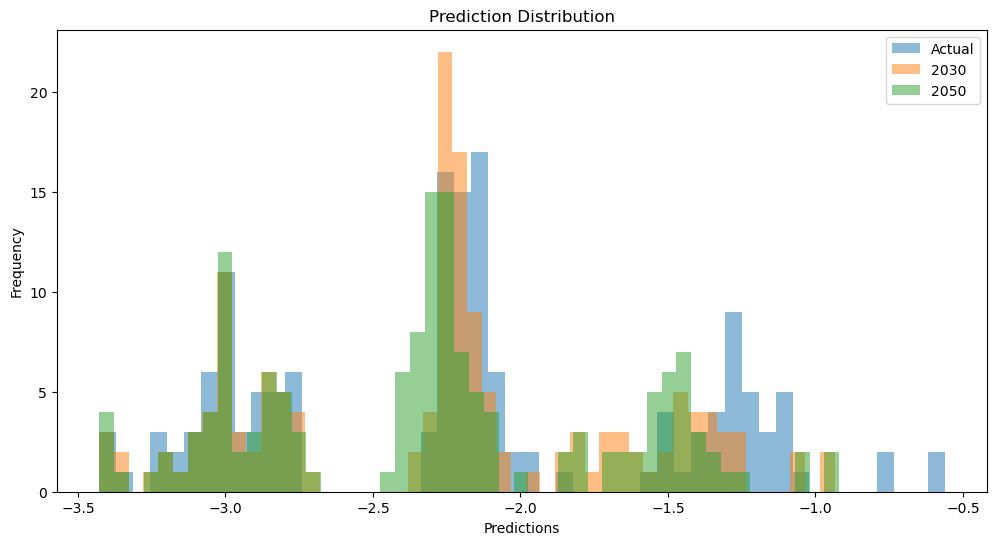

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.hist(y_pred_NO_CNN, bins=50, alpha=0.5, label='Actual')
plt.hist(y_pred_NO_CNN_2030, bins=50, alpha=0.5, label='2030')
plt.hist(y_pred_NO_CNN_2050, bins=50, alpha=0.5, label='2050')

plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.legend()
plt.title('Prediction Distribution')
plt.show()

In [17]:
y_pred_train_NO_CNN = best_model_NO_CNN.predict(X_train_NO_CNN)

df_ML_train_without_na['BayReg'] = y_pred_train_NO_CNN.flatten()
df_ML_test_without_na['BayReg'] = y_pred_NO_CNN.flatten()
df_ML_test_2030_without_na['BayReg'] = y_pred_NO_CNN_2030.flatten()
df_ML_test_2050_without_na['BayReg'] = y_pred_NO_CNN_2050.flatten()

C:\Users\alfon\AppData\Local\Temp\ipykernel_20264\936780853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_train_without_na['BayReg'] = y_pred_train_NO_CNN.flatten()
C:\Users\alfon\AppData\Local\Temp\ipykernel_20264\936780853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_test_without_na['BayReg'] = y_pred_NO_CNN.flatten()
C:\Users\alfon\AppData\Local\Temp\ipykernel_20264\936780853.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [18]:
# Let's adjust by adding the BayReg data and the rest of the Bayreg+CNN variables

from sklearn.preprocessing import StandardScaler
import numpy as np

# Define columns for CNN and non-CNN features
X_columns_CNN = ['global_regressor_V0','bio01', 'bio02', 'bio05', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_1.0', 'x0_2.0', 'x0_4.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0']
y_columns = ['log_vr_total']

# Select training and test sets
X_train_CNN = df_ML_train_without_na[X_columns_CNN]
X_test_CNN = df_ML_test_without_na[X_columns_CNN].copy()
X_test_CNN_2030 = df_ML_test_2030_without_na[X_columns_CNN].copy()
X_test_CNN_2050 = df_ML_test_2050_without_na[X_columns_CNN].copy()

X_train_CNN['BayReg'] = y_pred_train_NO_CNN.flatten()
X_test_CNN['BayReg'] = y_pred_NO_CNN.flatten()
X_test_CNN_2030['BayReg'] = y_pred_NO_CNN_2030.flatten()
X_test_CNN_2050['BayReg'] = y_pred_NO_CNN_2050.flatten()

# Select columns by name
columns_to_scale_CNN = ['global_regressor_V0','bio01', 'bio02', 'bio05', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub','BayReg']

# Create an instance of StandardScaler
scaler_CNN = StandardScaler()

# Fit the scaler only with the training data and then transform the training data
X_train_CNN[columns_to_scale_CNN] = scaler_CNN.fit_transform(X_train_CNN[columns_to_scale_CNN])

# Apply the transformation to the test data using the fitted values from the training data
X_test_CNN[columns_to_scale_CNN] = scaler_CNN.transform(X_test_CNN[columns_to_scale_CNN])
X_test_CNN_2030[columns_to_scale_CNN] = scaler_CNN.transform(X_test_CNN_2030[columns_to_scale_CNN])
X_test_CNN_2050[columns_to_scale_CNN] = scaler_CNN.transform(X_test_CNN_2050[columns_to_scale_CNN])

C:\Users\alfon\AppData\Local\Temp\ipykernel_20264\3107752691.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_CNN['BayReg'] = y_pred_train_NO_CNN.flatten()
C:\Users\alfon\AppData\Local\Temp\ipykernel_20264\3107752691.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_CNN[columns_to_scale_CNN] = scaler_CNN.fit_transform(X_train_CNN[columns_to_scale_CNN])


In [19]:
# Convert DataFrame to NumPy array and then to PyTorch tensor
X_test_tensor = torch.tensor(X_test_CNN.values, dtype=torch.float32)
X_test_tensor_2030 = torch.tensor(X_test_CNN_2030.values, dtype=torch.float32)
X_test_tensor_2050 = torch.tensor(X_test_CNN_2050.values, dtype=torch.float32)

In [20]:
# Load NN model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=32, dropout_rate=0.685):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Create an instance of the model with the same architecture
X_train_CNN_Bay_others = np.load('../../Data/X_train_CNN_Bay_others.npy')
input_dim = X_train_CNN_Bay_others.shape[1]
ensemble_model = NeuralNetwork(input_dim)

# Load the weights saved in the model
ensemble_model.load_state_dict(torch.load('../../Data/Calibrated_models/ensemble_model_V0.pth'))

# Set up the model for evaluation
ensemble_model.eval()

NeuralNetwork(
  (fc1): Linear(in_features=24, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.685, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.685, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
from scipy.stats import pearsonr, spearmanr

# Make predictions from the ensemble model
with torch.no_grad():
    y_pred_test_loaded_model = ensemble_model(X_test_tensor).numpy()
    y_pred_test_loaded_model_2030 = ensemble_model(X_test_tensor_2030).numpy()
    y_pred_test_loaded_model_2050 = ensemble_model(X_test_tensor_2050).numpy()

In [22]:
import numpy as np

mean_pred_test = np.mean(y_pred_test_loaded_model)
mean_pred_test_2030 = np.mean(y_pred_test_loaded_model_2030)
mean_pred_test_2050 = np.mean(y_pred_test_loaded_model_2050)

print("Mean prediction for the current test set:", mean_pred_test)
print("Mean prediction for 2030:", mean_pred_test_2030)
print("Mean prediction for 2050:", mean_pred_test_2050)


Mean prediction for the current test set: -1.9555598
Mean prediction for 2030: -1.9890531
Mean prediction for 2050: -1.9811695


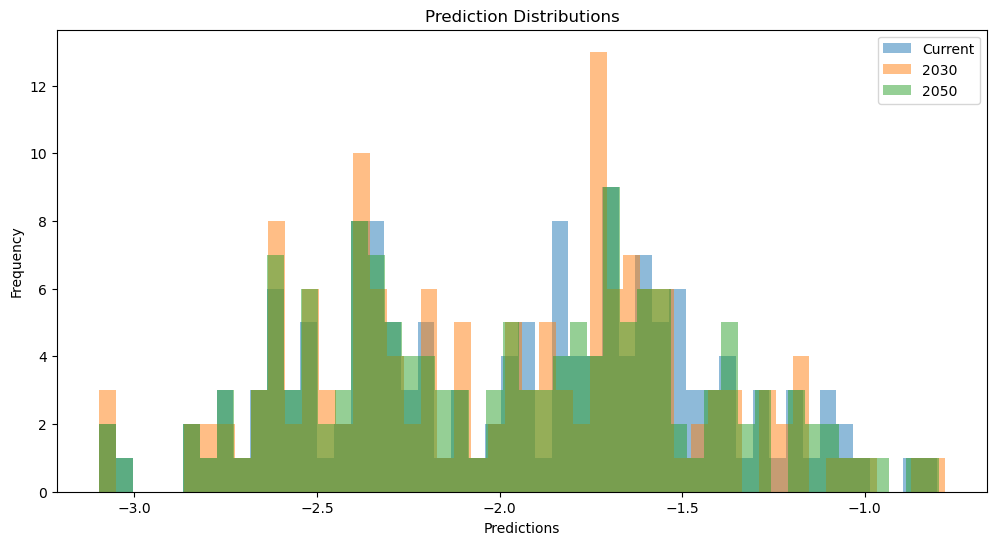

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.hist(y_pred_test_loaded_model, bins=50, alpha=0.5, label='Current')
plt.hist(y_pred_test_loaded_model_2030, bins=50, alpha=0.5, label='2030')
plt.hist(y_pred_test_loaded_model_2050, bins=50, alpha=0.5, label='2050')

plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.legend()
plt.title('Prediction Distributions')
plt.show()


In [24]:
# Plot results and color by latitude and country

CropPol_field_level_data = pd.read_csv('../../Data/CropPol_field_level_data.csv')

df_ML_test_without_na_aux = df_ML_test_without_na.copy()

# Convert columns to the same type, for example, string
CropPol_field_level_data['study_id'] = CropPol_field_level_data['study_id'].astype(str)
CropPol_field_level_data['site_id'] = CropPol_field_level_data['site_id'].astype(str)
CropPol_field_level_data['sampling_year'] = CropPol_field_level_data['sampling_year'].astype(str)

df_ML_test_without_na_aux['study_id'] = df_ML_test_without_na_aux['study_id'].astype(str)
df_ML_test_without_na_aux['site_id'] = df_ML_test_without_na_aux['site_id'].astype(str)
df_ML_test_without_na_aux['sampling_year'] = df_ML_test_without_na_aux['sampling_year'].astype(str)


df_merged_lat_country = df_ML_test_without_na_aux.merge(
    CropPol_field_level_data[['study_id', 'site_id', 'sampling_year', 'latitude', 'country']],
    on=['study_id', 'site_id', 'sampling_year'],
    how='left'
)

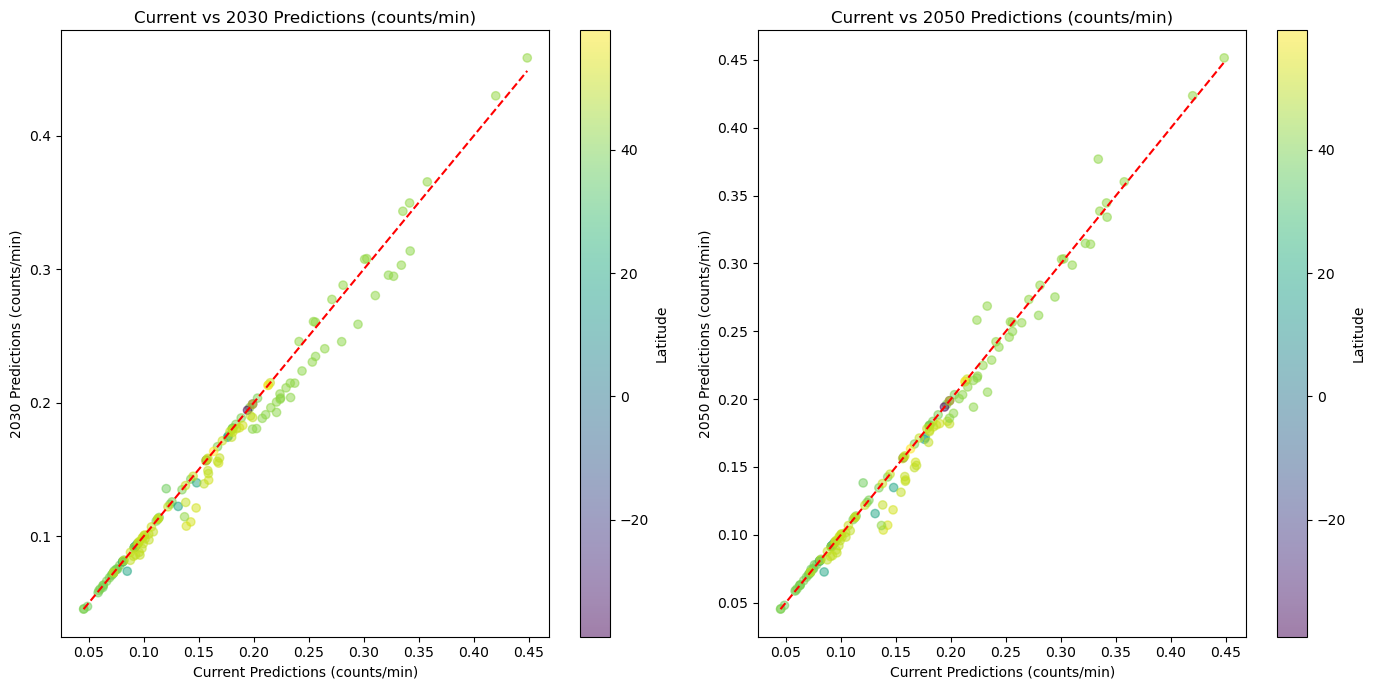

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Transform predictions back to the natural scale
y_pred_test_loaded_model_natural = np.exp(y_pred_test_loaded_model)
y_pred_test_loaded_model_2030_natural = np.exp(y_pred_test_loaded_model_2030)
y_pred_test_loaded_model_2050_natural = np.exp(y_pred_test_loaded_model_2050)

# Extract latitude values for color mapping
latitudes = df_merged_lat_country['latitude'].values

# Normalize latitude values for color mapping
norm = plt.Normalize(latitudes.min(), latitudes.max())
colors = plt.cm.viridis(norm(latitudes))

plt.figure(figsize=(14, 7))

# Scatter plot for Current vs 2030 predictions
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_pred_test_loaded_model_natural, y_pred_test_loaded_model_2030_natural, c=latitudes, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Latitude')
plt.xlabel('Current Predictions (counts/min)')
plt.ylabel('2030 Predictions (counts/min)')
plt.title('Current vs 2030 Predictions (counts/min)')
plt.plot([min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 
         [min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 'r--')

# Scatter plot for Current vs 2050 predictions
plt.subplot(1, 2, 2)
scatter = plt.scatter(y_pred_test_loaded_model_natural, y_pred_test_loaded_model_2050_natural, c=latitudes, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Latitude')
plt.xlabel('Current Predictions (counts/min)')
plt.ylabel('2050 Predictions (counts/min)')
plt.title('Current vs 2050 Predictions (counts/min)')
plt.plot([min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 
         [min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 'r--')

plt.tight_layout()
plt.show()

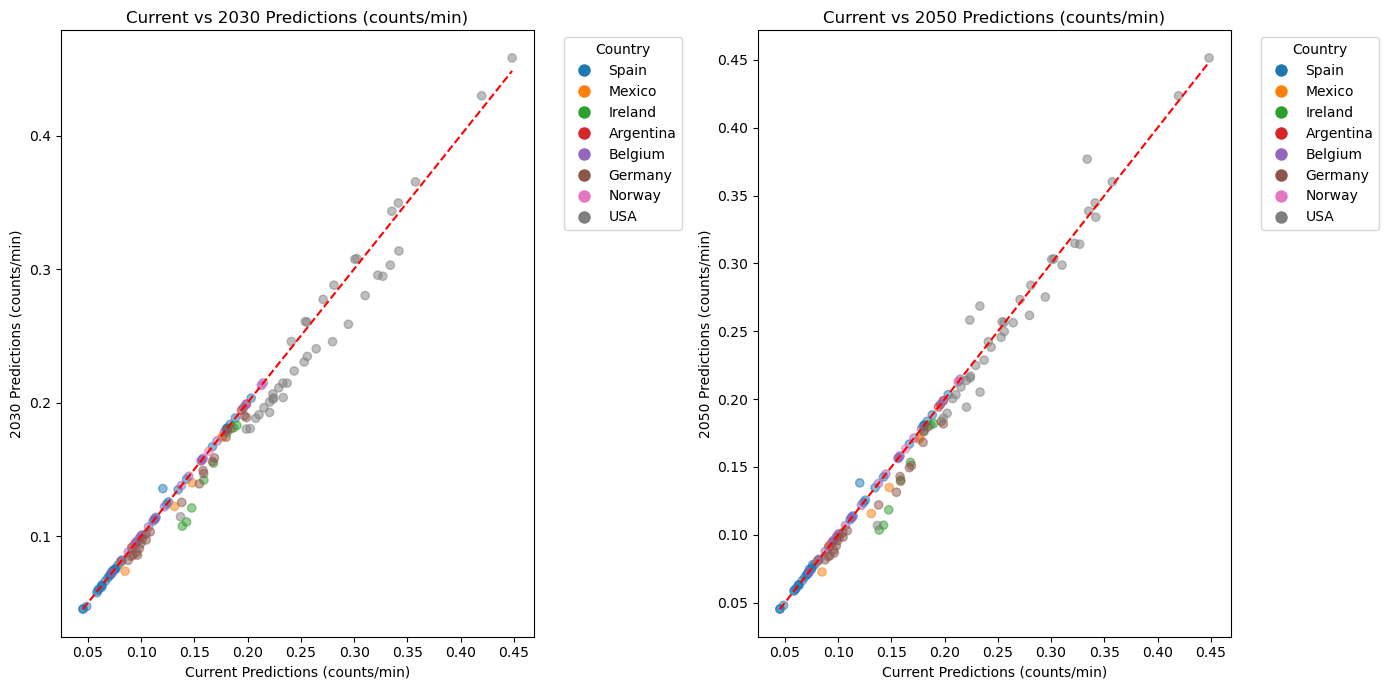

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# Define a color palette with 8 distinct colors
color_palette = plt.get_cmap('tab10')

# Create a mapping from country names to colors
unique_countries = df_merged_lat_country['country'].unique()
num_colors = min(len(unique_countries), 8)  # Use at most 8 colors
color_map = {country: color_palette(i) for i, country in enumerate(unique_countries[:num_colors])}

# Assign colors to each point based on the country
country_colors = df_merged_lat_country['country'].map(color_map)

# Transform predictions back to the natural scale
y_pred_test_loaded_model_natural = np.exp(y_pred_test_loaded_model)
y_pred_test_loaded_model_2030_natural = np.exp(y_pred_test_loaded_model_2030)
y_pred_test_loaded_model_2050_natural = np.exp(y_pred_test_loaded_model_2050)

plt.figure(figsize=(14, 7))

# Scatter plot for Current vs 2030 predictions
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_pred_test_loaded_model_natural, y_pred_test_loaded_model_2030_natural, c=country_colors, alpha=0.5)
plt.xlabel('Current Predictions (counts/min)')
plt.ylabel('2030 Predictions (counts/min)')
plt.title('Current vs 2030 Predictions (counts/min)')
plt.plot([min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 
         [min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 'r--')

# Add legend for countries
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[country], markersize=10, label=country)
           for country in unique_countries[:num_colors]]
plt.legend(handles=handles, title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Scatter plot for Current vs 2050 predictions
plt.subplot(1, 2, 2)
scatter = plt.scatter(y_pred_test_loaded_model_natural, y_pred_test_loaded_model_2050_natural, c=country_colors, alpha=0.5)
plt.xlabel('Current Predictions (counts/min)')
plt.ylabel('2050 Predictions (counts/min)')
plt.title('Current vs 2050 Predictions (counts/min)')
plt.plot([min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 
         [min(y_pred_test_loaded_model_natural), max(y_pred_test_loaded_model_natural)], 'r--')

# Add legend for countries
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[country], markersize=10, label=country)
           for country in unique_countries[:num_colors]]
plt.legend(handles=handles, title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
